In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numba import jit, float64
from multiprocessing import Pool
import time
from collections import Counter

# Vizualize the attractor structure in 3D

using [Potree](http://potree.org/), a "WebGL based point cloud renderer for large point clouds"


- Point cloud to 3D:

A first approach is to directly use the points obtain from the ODE solver as 3d point cloud. The problem is that the density of points is not uniform, leading to poor 3d render.

A second approach is to evaluate the density on a regular grid. Using 3D sparse arrays. However, [sparse](https://sparse.pydata.org/en/latest/quickstart.html) library is not very usefull here,
use collections.Counter instead 

_note:_ mutliproc is not very usefull, the bottleneck is memory

In [3]:
@jit(float64[:](float64[:], float64), nopython=True)
def thomas_attractor(xyz, b):
    ''' ODE for Thomas attractor
        xyz: point position, 1d array, float64
        b: coefficient, float64
        
        use numba JIT
    '''
    sin_xyz = np.sin(xyz)
    dYdt = -b*xyz
    dYdt[0] += sin_xyz[1]
    dYdt[1] += sin_xyz[2]
    dYdt[2] += sin_xyz[0]
    return dYdt/np.sqrt(np.sum(dYdt**2))

In [4]:
def burn(b):
    y0 = np.random.randn(3)*3
    
    t_span = np.linspace(0, 100, 11)
    sol = odeint(lambda y, t: thomas_attractor(y, b),
                 y0, t_span)
    y1 = sol[-1, :]
    return y1

In [38]:
# init
b = 0.192
half_attractor_size = 4.2  # demi axe
nbr_pixel = 2000
print('voxel size:', half_attractor_size*2/nbr_pixel )
voxel_size = half_attractor_size*2/nbr_pixel

voxel size: 0.004200000000000001


In [39]:
# Burn (multiprocessing)
t_start = time.time()
with Pool(4) as p:
    points = p.map(burn, [b, ]*5000, chunksize=10)

print('elapsed (s)', time.time() - t_start)
print(len(points))

elapsed (s) 5.334744691848755
5000


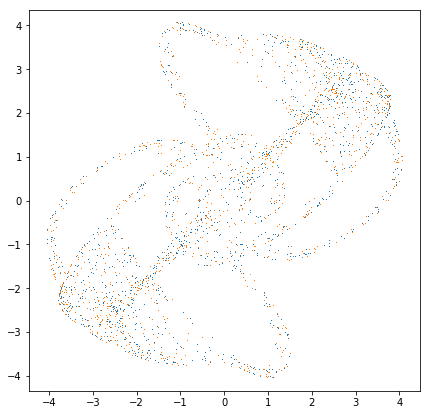

In [40]:
points_array = np.vstack(points)

plt.figure(figsize=(7, 7));
plt.axis('equal');
plt.plot(points_array[:, 0], points_array[:, 1], ',', alpha=0.8);
plt.plot(-points_array[:, 0], -points_array[:, 1], ',', alpha=0.8);

In [41]:
def tuplize(xyz):
    XYZ_px = ( (xyz + half_attractor_size)/(2*half_attractor_size) * nbr_pixel ).astype(int)
    return [tuple(ijk) for ijk in XYZ_px]

In [42]:
#dt = voxel_size*10
# note: the time step is much larger than the voxel size --> stats over many samples

def integrate(y0):

    t_span = t_span = np.linspace(0, 100, 7000)# np.arange(0, 500, dt)
    xyz = odeint(lambda y, t: thomas_attractor(y, b),
                 y0, t_span)
    return xyz

In [43]:
# init
cube = Counter()
len_cube = []

In [44]:
t_start = time.time()

for k in range(100):
    # burn
    points = [burn(b) for _ in range(1000)]
    #print('elapsed (s)', time.time() - t_start)

    for y0 in points:
        xyz = integrate(y0)
        cube.update(tuplize(xyz))

    print('elapsed (s)', time.time() - t_start)

    print(len(cube), len(points))
    len_cube.append((sum(cube.values()), len(cube)))

elapsed (s) 16.25030016899109
3309915 1000
elapsed (s) 32.11561441421509
4453289 1000
elapsed (s) 48.153559923172
5068442 1000
elapsed (s) 64.46003770828247
5451768 1000
elapsed (s) 81.61213850975037
5711454 1000
elapsed (s) 97.67435669898987
5912307 1000
elapsed (s) 113.8169059753418
6059629 1000
elapsed (s) 129.83877897262573
6177163 1000
elapsed (s) 147.13150906562805
6277001 1000
elapsed (s) 163.68273901939392
6357934 1000
elapsed (s) 180.17408180236816
6428204 1000
elapsed (s) 196.57613015174866
6488285 1000
elapsed (s) 213.2611665725708
6539570 1000
elapsed (s) 230.19820094108582
6585797 1000
elapsed (s) 247.01978397369385
6628087 1000
elapsed (s) 263.16825580596924
6666296 1000
elapsed (s) 279.49587988853455
6699500 1000
elapsed (s) 295.71215081214905
6731896 1000
elapsed (s) 312.40413880348206
6761023 1000
elapsed (s) 331.28911542892456
6788113 1000
elapsed (s) 348.89546036720276
6811817 1000
elapsed (s) 365.5653989315033
6833880 1000
elapsed (s) 382.1351001262665
6855199 1000


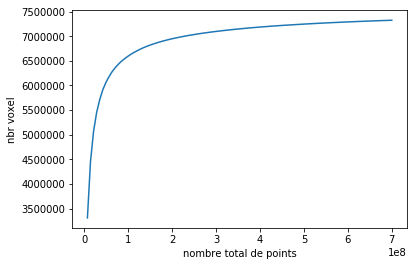

In [45]:
plt.plot(*list(zip(*len_cube)));
plt.xlabel('nombre total de points');
plt.ylabel('nbr voxel'); 

nbr of non zero voxel: 7325454
nbr of counts: 700000000


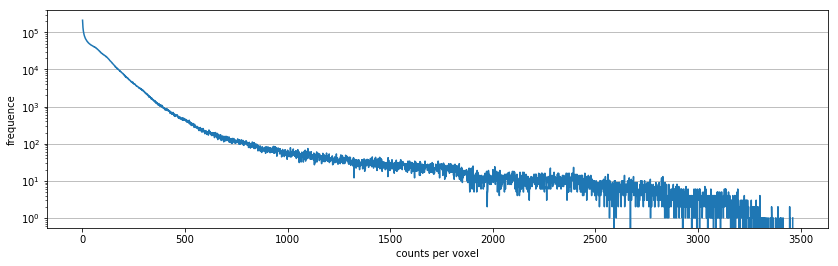

In [46]:
# stats
print('nbr of non zero voxel:', len(cube))
total_counts = sum(cube.values())
print('nbr of counts:', total_counts)

freqs = np.bincount([x for x in cube.values()])

plt.figure(figsize=(14, 4));
plt.semilogy(np.arange(1, len(freqs)), freqs[1:]);
plt.ylabel('frequence'); plt.grid(axis='y')
plt.xlabel('counts per voxel'); 

### Save to text file

In [47]:
import matplotlib.cm as cm

In [48]:
def color_convertor(value):
    return cm.Reds(value, bytes=False)[:3]

In [51]:
min_count = int( len(freqs)*0.01 )
max_count = int( len(freqs)*0.9 )

nbr_voxel = np.sum( freqs[min_count:] )
print(nbr_voxel, 'points')

4758540 points


In [52]:
with open(f'data/pointcloud_{nbr_pixel}px_{nbr_voxel}points.xyz', 'a') as f:
    
    for ijk, value in cube.items():
        
        if value < min_count:
            continue
        else:
            density = np.clip((value - min_count)/(max_count - min_count), 0, 1)*0.8 + 0.2
            xyz =  (np.array(ijk)/nbr_pixel - 0.5)*half_attractor_size*2
            to_str = [f'{u}' for u in np.hstack([xyz, color_convertor(density)])]
            line = ' '.join(to_str) + '\n'
    
            f.write(line)

### PotreeConvertor

- Path to use     PotreeConverter:

        
        export PATH="~/Softwares/potree/PotreeConverter/master/build/PotreeConverter/:$PATH"

- Command to convert:

        PotreeConverter -p --page-template ./page_template/ -i thomas_pointcloud.xyz
    
        PotreeConverter -f xyzrgb -color-range 1 -a RGB  -i thomas_pointcloud.xyz

![potree_v3_1000px.png](./potree_v3_1000px.png)

![2000px_4.7Mpoints.png](./2000px_4.7Mpoints.png)

### Next:

- noise: https://core.ac.uk/download/pdf/34480918.pdf
- speed up?  go full Julia?